In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

In [2]:
# Compute inertia and assign labels to closest centroid
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

def compute_inertia(centroids, data, threshold=100000, distance_metric='manhattan'):
    # Choose distance metric
    if distance_metric == 'euclidean':
        distances = euclidean_distances(data, centroids)
    elif distance_metric == 'manhattan':
        distances = manhattan_distances(data, centroids)
    else:
        raise ValueError("Unsupported distance metric. Choose 'euclidean' or 'manhattan'.")

    labels = np.argmin(distances, axis=1)
    min_distances = np.min(distances, axis=1)

    # Assign -1 for distances greater than threshold
    labels[min_distances > threshold] = -1

    # Compute inertia for assigned data points
    assigned_data_points = data[labels != -1]
    if len(assigned_data_points) > 0:
        assigned_labels = labels[labels != -1]
        inertia = np.sum((assigned_data_points - centroids[assigned_labels]) ** 2)
    else:
        inertia = 0

    # Calculate additional metrics if needed
    num_outliers = np.sum(labels == -1)
    average_distance = np.mean(min_distances[labels != -1]) if len(assigned_data_points) > 0 else 0

    return inertia

In [3]:
class Cuckoo:
    def __init__(self, data, n_clusters):
        self.position = data[np.random.choice(data.shape[0], n_clusters, replace=False), :]
        self.fitness = compute_inertia(self.position, data)


In [4]:
def cuckoo_kmeans(data, n_clusters, n_nests=10, max_iter=100, pa=0.25):
    cuckoos = [Cuckoo(data, n_clusters) for _ in range(n_nests)]

    for _ in range(max_iter):
        for cuckoo in cuckoos:
            # Generate new solution and calculate its fitness
            new_position = cuckoo.position + np.random.uniform(-1, 1, cuckoo.position.shape)
            new_fitness = compute_inertia(new_position, data)

            # Randomly choose a nest
            random_nest = np.random.choice(cuckoos)

            # Replace the worst solution with the new one if it's better
            if new_fitness < random_nest.fitness:
                random_nest.position = new_position
                random_nest.fitness = new_fitness

        # Abandon worse nests and build new ones
        cuckoos.sort(key=lambda x: x.fitness)
        n_abandon = int(n_nests * pa)
        for i in range(n_abandon, n_nests):
            cuckoos[i] = Cuckoo(data, n_clusters)

    best_nest = cuckoos[0]
    final_kmeans = KMeans(n_clusters=n_clusters, init=np.array(best_nest.position), n_init=1, max_iter=300)
    final_kmeans.fit(data)
    return final_kmeans

In [5]:
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stopwords, stemmer, and punctuation set
stop_words = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert to lowercase, remove punctuation, remove stopwords, and stem
    processed_tokens = [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stop_words and word not in punctuation_set]
    # Re-join processed tokens into a single string
    return ' '.join(processed_tokens)

In [7]:
newsgroups_dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), random_state=42)

In [8]:
processed_data = [preprocess_text(doc) for doc in newsgroups_dataset.data]
# Use TfidfVectorizer to convert the raw text into TF-IDF features
print("Vectorizing the text data...")
import gensim.downloader as api
from sklearn.decomposition import PCA
# Load Word2Vec model trained on Google News dataset
print("Loading Word2Vec model...")
word2vec_model = api.load('word2vec-google-news-300')

# Define a function to get the vector representation of a document
def document_vector(doc):
    # Remove punctuation and tokenize the document
    tokens = [word.lower() for word in word_tokenize(doc) if word.lower() not in punctuation_set]
    # Filter out tokens that are not in the Word2Vec model's vocabulary
    tokens = [word for word in tokens if word in word2vec_model.key_to_index]
    if len(tokens) == 0:
        return np.zeros(word2vec_model.vector_size)
    # Calculate the mean of word vectors for tokens in the document
    return np.mean(word2vec_model[tokens], axis=0)

# Obtain Word2Vec embeddings for each document
print("Obtaining Word2Vec embeddings for each document...")
word2vec_embeddings = np.array([document_vector(doc) for doc in processed_data])


Vectorizing the text data...
Loading Word2Vec model...
Obtaining Word2Vec embeddings for each document...


In [9]:
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_matrix_reduced = svd.fit_transform(word2vec_embeddings)

In [10]:
n_clusters = 2
kmeans = cuckoo_kmeans(tfidf_matrix_reduced, n_clusters)
print("Cluster centers:", kmeans.cluster_centers_)
print("Labels:", kmeans.labels_)
#GWO-Kmeans on 20newsgroups


Cluster centers: [[ 8.15837694e-01  2.08075490e-01 -6.03599367e-02  1.12215937e-02
   1.60906549e-02 -8.97646628e-03  1.76625055e-03  1.03228059e-03
   8.29355543e-03  1.17065108e-03 -1.97869861e-03 -1.54817443e-04
  -2.41490687e-03 -7.59106295e-04 -5.37043457e-04 -3.96236177e-03
   1.98842361e-03  1.82736160e-03  2.71682300e-04 -7.21141491e-05
   7.13612347e-04 -2.18831159e-03 -1.94565058e-03  6.54456838e-04
   1.20165608e-04  2.34832570e-03 -1.37749467e-03  6.13223013e-04
  -8.31305324e-04  2.32109219e-04  7.65053375e-06 -5.75174039e-04
  -5.92526699e-04  1.70984285e-04 -2.55454727e-05  8.22507879e-05
  -1.00664093e-03 -1.17240945e-04  2.74357361e-04 -1.59055226e-03
  -3.97658276e-04 -1.84188797e-04 -4.48921385e-05 -2.70575830e-04
   5.53795155e-04  3.34471258e-04  1.34452918e-04  3.45118069e-04
   5.40009147e-05 -8.39647573e-04 -6.83220479e-04  4.32260316e-04
   7.73867641e-04 -5.60798933e-04 -8.37992950e-05  2.75770257e-04
  -1.05859780e-03  1.06060100e-03  2.33007042e-04  6.253288

In [11]:
silhouette = silhouette_score(tfidf_matrix_reduced, kmeans.labels_)
davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced, kmeans.labels_)
calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced, kmeans.labels_)

print("Cluster centers:", kmeans.cluster_centers_)
print("Labels:", kmeans.labels_)
print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

Cluster centers: [[ 8.15837694e-01  2.08075490e-01 -6.03599367e-02  1.12215937e-02
   1.60906549e-02 -8.97646628e-03  1.76625055e-03  1.03228059e-03
   8.29355543e-03  1.17065108e-03 -1.97869861e-03 -1.54817443e-04
  -2.41490687e-03 -7.59106295e-04 -5.37043457e-04 -3.96236177e-03
   1.98842361e-03  1.82736160e-03  2.71682300e-04 -7.21141491e-05
   7.13612347e-04 -2.18831159e-03 -1.94565058e-03  6.54456838e-04
   1.20165608e-04  2.34832570e-03 -1.37749467e-03  6.13223013e-04
  -8.31305324e-04  2.32109219e-04  7.65053375e-06 -5.75174039e-04
  -5.92526699e-04  1.70984285e-04 -2.55454727e-05  8.22507879e-05
  -1.00664093e-03 -1.17240945e-04  2.74357361e-04 -1.59055226e-03
  -3.97658276e-04 -1.84188797e-04 -4.48921385e-05 -2.70575830e-04
   5.53795155e-04  3.34471258e-04  1.34452918e-04  3.45118069e-04
   5.40009147e-05 -8.39647573e-04 -6.83220479e-04  4.32260316e-04
   7.73867641e-04 -5.60798933e-04 -8.37992950e-05  2.75770257e-04
  -1.05859780e-03  1.06060100e-03  2.33007042e-04  6.253288

In [12]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
Labels_save=[];
for n_clusters in range(2, 21):
    # Run PSO-KMeans with the current number of clusters
    kmeans =  cuckoo_kmeans(tfidf_matrix_reduced, n_clusters)
    
    # Calculate metrics
    silhouette = silhouette_score(tfidf_matrix_reduced, kmeans.labels_)
    print(silhouette)
    davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced, kmeans.labels_)
    
    # Store metrics
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)


0.1011593110544239
0.12086412050546891
0.0448569801550795
0.07197532308612478
0.025852266185801227
0.06244417084855806
0.05975231512911424
0.06352625591895952
0.05624614533953169
0.05091469327240349
0.05975501655517385
0.05028395276855622
0.0434194573605546
0.04031014542413857
0.04153090041274747
0.045588519399954626
0.0397612689507131
0.03785769992649013
0.03933821746493704


C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_3684\1341984160.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_3684\1341984160.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


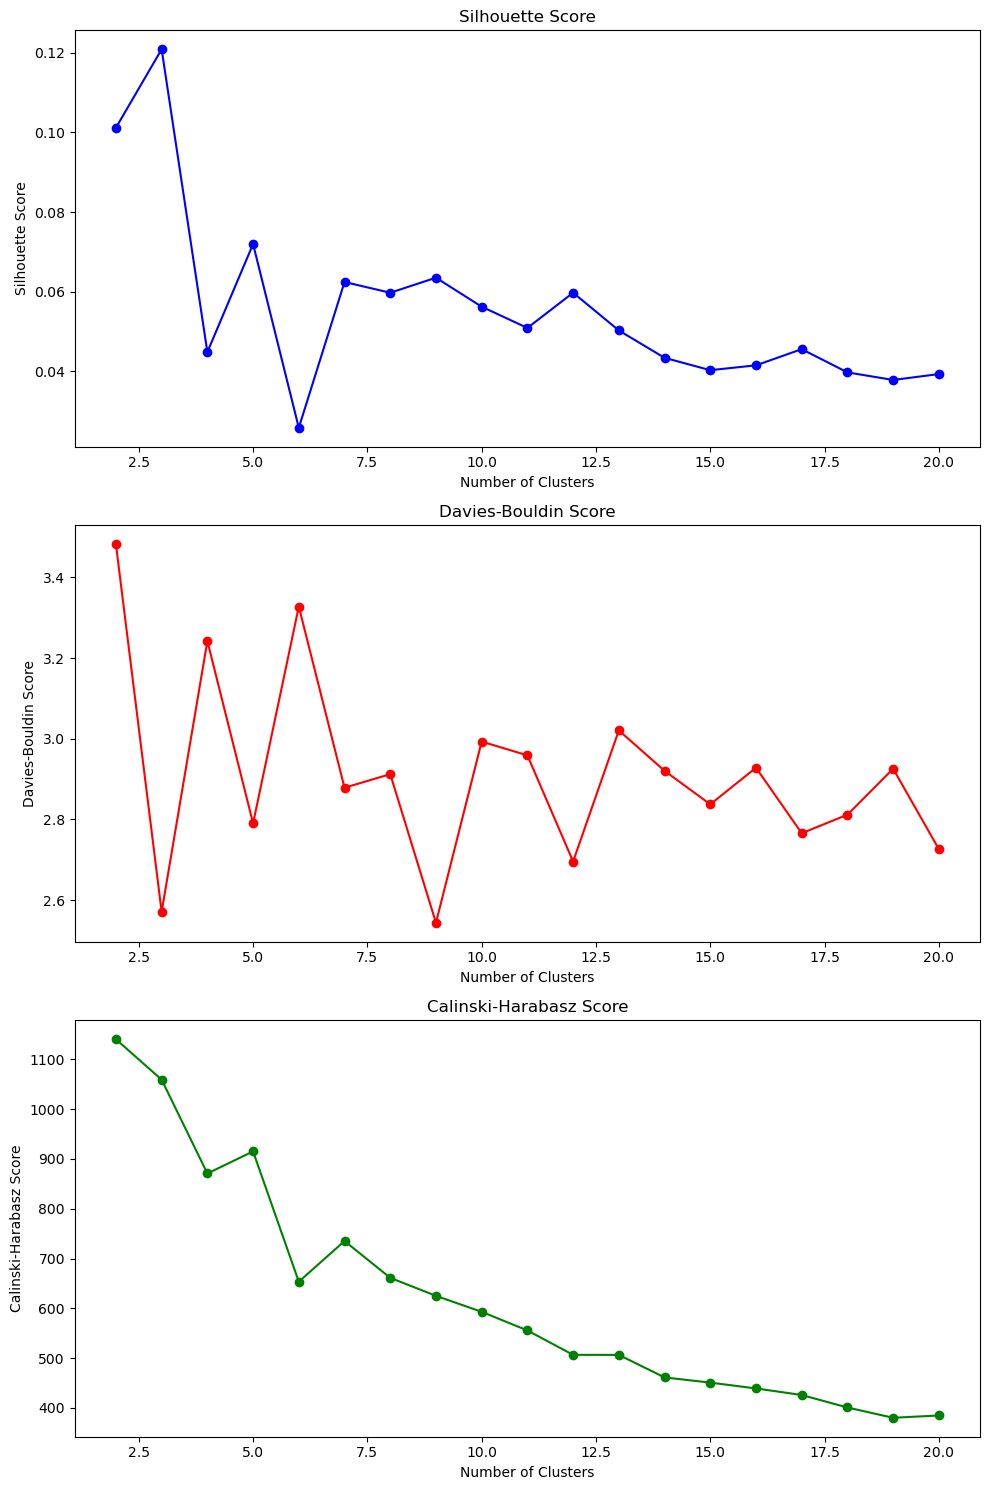

In [13]:
import matplotlib.pyplot as plt
# Plotting the metrics
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Silhouette Score
axs[0].plot(range(2, 21), silhouette_scores, marker='o', linestyle='-', color='blue')
axs[0].set_title('Silhouette Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')
plt.savefig("Silhouette Score_News_countCuckoo-Kmeans.png")

# Davies-Bouldin Score
axs[1].plot(range(2, 21), davies_bouldin_scores, marker='o', linestyle='-', color='red')
axs[1].set_title('Davies-Bouldin Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Davies-Bouldin Score')
plt.tight_layout()
plt.savefig("Davies-Bouldin Score_News_countCuckoo-Kmeans.png")
# Calinski-Harabasz Score
axs[2].plot(range(2, 21), calinski_harabasz_scores, marker='o', linestyle='-', color='green')
axs[2].set_title('Calinski-Harabasz Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('Calinski-Harabasz Score')
plt.tight_layout()
plt.savefig("Calinski-Harabasz Score_News_countCuckoo-Kmeans.png")
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
data = {'silhouette_scores':silhouette_scores,'davies_bouldin_scores': davies_bouldin_scores,
        'calinski_harabasz_scores': calinski_harabasz_scores}
df=pd.DataFrame(data,index=range(2, 21))

In [15]:
df.to_csv('News_word2vec_CUCKOO-Kmeans.csv')